In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 9)
sns.set(rc={"figure.figsize":(14, 5)})

## Analysing Data


In [3]:
df = pd.read_csv('heart_2020.csv')
df['HeartDisease'] = df['HeartDisease'].replace(['Yes', 'No'], [1, 0])
CATEGORICAL_FEATURES = []
NUMERIC_FEATURES = []
for i in df.columns:
    if df[i].dtype == 'object':
        CATEGORICAL_FEATURES.append(i)
    elif df[i].dtype == 'float64':
        NUMERIC_FEATURES.append(i)
    else:
        continue


In [4]:
df.dtypes

HeartDisease          int64
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth        int64
MentalHealth          int64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime             int64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

In [5]:
for i in CATEGORICAL_FEATURES:
    print(df.groupby(str(i)).HeartDisease.agg(['count', 'mean']).sort_values('mean', ascending=False))
for i in NUMERIC_FEATURES:
    print(df.groupby(str(i)).HeartDisease.agg(['count', 'mean']).sort_values('mean', ascending=False))


          count      mean
Smoking                  
Yes      131908  0.121577
No       187887  0.060334
                  count      mean
AlcoholDrinking                  
No               298018  0.088022
Yes               21777  0.052395
         count      mean
Stroke                  
Yes      12069  0.363659
No      307726  0.074690
              count      mean
DiffWalking                  
Yes           44410  0.225805
No           275385  0.062985
         count      mean
Sex                     
Male    151990  0.106185
Female  167805  0.066947
             count      mean
AgeCategory                 
80 or older  24153  0.225603
75-79        21482  0.188483
70-74        31065  0.156028
65-69        34151  0.120084
60-64        33686  0.098765
55-59        29757  0.073999
50-54        25382  0.054487
45-49        21791  0.034143
40-44        21006  0.023136
35-39        20550  0.014404
30-34        18753  0.012051
25-29        16955  0.007844
18-24        21064  0.006172
     

<AxesSubplot:xlabel='Race', ylabel='HeartDisease'>

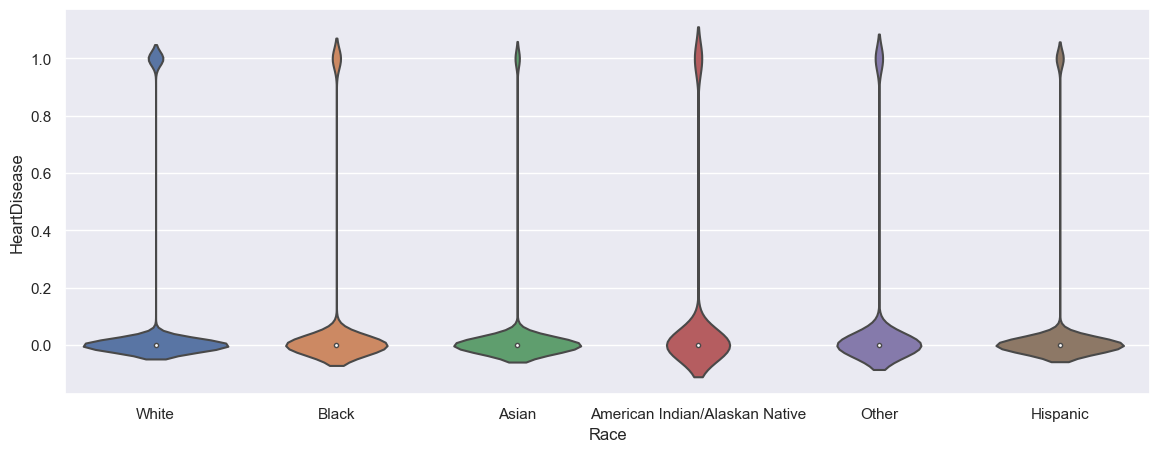

In [7]:
# Race => cultural values, habits, economy,....
sns.violinplot(y='HeartDisease', x='Race', data=df)

In [9]:
df.groupby('SleepTime').HeartDisease.agg(['mean', 'count']).sort_values('mean')


,mean,count
SleepTime,,
21,0.000000,2
23,0.000000,3
7,0.064705,97751
6,0.081339,66721
8,0.085633,97602
17,0.095238,21
9,0.105729,16041
5,0.105817,19184
1,0.108893,551


In [6]:
df.corr()['HeartDisease'].to_frame().T

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime
HeartDisease,1.0,0.051803,0.170721,0.028591,0.008327


## Pre-processing

In [10]:
def preprocess_dataframe(df):
    df = df.copy()
    
    df['HeartDisease'] = df['HeartDisease'].replace(['Yes', 'No'], [1, 0])
    
    return df
    
df = pd.read_csv('heart_2020.csv')


CATEGORICAL_FEATURES = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
NUMERIC_FEATURES = ['PhysicalHealth']
del df['SleepTime']
del df['MentalHealth']
del df['BMI']

df = preprocess_dataframe(df)


## Train The Model (unfinished)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

df_train, df_test = train_test_split(df, test_size=0.25, random_state=0)
num_df = df_train[NUMERIC_FEATURES].copy()
cat_df = df_train[CATEGORICAL_FEATURES].copy()


def fit_transformers(df_train):
    one_hot_encoder = OneHotEncoder(drop='first')
    one_hot_encoder.fit(df_train[CATEGORICAL_FEATURES])
    return one_hot_encoder

def compute_features(df, one_hot_encoder):
    df = preprocess_dataframe(df)
    cat_features = one_hot_encoder.transform(df[CATEGORICAL_FEATURES])
    cat_df = pd.DataFrame(cat_features.todense(), columns=one_hot_encoder.get_feature_names()).reset_index(drop=True)
    num_df = df[NUMERIC_FEATURES].reset_index(drop=True)
    features = pd.concat([num_df, cat_df], axis=1)
    return cat_df

one_hot_encoder = fit_transformers(df_train)



X_train = compute_features(df_train, one_hot_encoder)
y_train = df_train.HeartDisease

X_test = compute_features(df_test, one_hot_encoder)
y_test = df_test.HeartDisease

c:\Users\Desktop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Desktop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

model = LogisticRegression()
baseline = DummyClassifier(strategy='most_frequent')
advanced_model = XGBClassifier()

model.fit(X_train, y_train)
baseline.fit(X_train, y_train)
advanced_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [13]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     73137
           1       0.53      0.10      0.17      6812

    accuracy                           0.92     79949
   macro avg       0.73      0.55      0.56     79949
weighted avg       0.89      0.92      0.89     79949



In [14]:
print(classification_report(y_test, advanced_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     73137
           1       0.54      0.09      0.15      6812

    accuracy                           0.92     79949
   macro avg       0.73      0.54      0.55     79949
weighted avg       0.89      0.92      0.89     79949



In [15]:
print(classification_report(y_test, baseline.predict(X_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     73137
           1       0.00      0.00      0.00      6812

    accuracy                           0.91     79949
   macro avg       0.46      0.50      0.48     79949
weighted avg       0.84      0.91      0.87     79949



In [16]:
model.predict_proba(X_test)

array([[0.86025572, 0.13974428],
       [0.98951482, 0.01048518],
       [0.96584985, 0.03415015],
       ...,
       [0.89629982, 0.10370018],
       [0.98276107, 0.01723893],
       [0.99555201, 0.00444799]])

In [17]:
index = advanced_model.predict(X_test).argmax()
index

5

In [18]:
advanced_model.predict(X_test)[:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [19]:
y_test.sample(6)

57623     0
155191    0
119465    0
249541    0
18706     0
96007     0
Name: HeartDisease, dtype: int64